In [1]:
import numpy as np
from statistics import mean
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random 

np.random.seed(42)

In [2]:

class SurgicalEnvironment:
    def __init__(self):
        # Define the size of the surgical environment
        self.dimension = 10

        # Initialize the surgical grid with default values
        self.surgical_grid = -np.ones((self.dimension + 1, self.dimension + 1), dtype=np.int32)

        # Initial scalpel position
        self.scalpel_position = (4, 3)
        self.original_scalpel_coords = (4, 3)

        # Define object, target, bladder, avoid, and peritoneum positions and their values
        self.object_positions = [(4, 4), (4, 5), (4, 6), (5, 4), (5, 5), (5, 6)] #prostate
        self.object_value = 128

        self.target_positions = [(3, 4), (3, 6), (4, 3), (4, 7), (6, 5), (3, 5)] #the points to cut
        self.target_value = 16

        self.bladder_positions = [(1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 5)] #the bladder, it must be avoided more then other points
        self.bladder_value = 32

        self.avoid_positions = [(2, 4), (2, 3), (2, 6), (2, 7), (7, 5), (8, 5), (9, 5), (4, 2), (4, 8)] #point to be avoided such as nerves and bladder conducts
        self.avoid_value = 64

        self.peritoneum_value = 255
        self.scalpel_value = 8

        self.path_history = []
        self.actions_taken = []

        # Define the action space
        self.action_space = [0, 1, 2, 3]
        self.actions_dict = {0: 'up', 1: 'right', 2: 'down', 3: 'left'}
        self.num_actions = len(self.action_space)

    def create_environment(self):
        # Set boundary values to 0
        self.surgical_grid[0] = self.surgical_grid[-1] = self.surgical_grid[:, 0] = self.surgical_grid[:, -1] = 0

        # Set values for objects, targets, bladder, and positions to avoid
        for position in self.object_positions:
            self.surgical_grid[position] = self.object_value

        for position in self.target_positions:
            self.surgical_grid[position] = self.target_value

        for position in self.avoid_positions:
            self.surgical_grid[position] = self.avoid_value

        for position in self.bladder_positions:
            self.surgical_grid[position] = self.bladder_value

        # Set remaining undefined points to peritoneum value
        self.surgical_grid[self.surgical_grid == -1] = self.peritoneum_value

        return self.surgical_grid.copy()

    def display_environment(self):
        # Display the surgical environment
        plt.figure(figsize=(5, 5))
        plt.imshow(self.surgical_grid)
        plt.show()

    def perform_action(self, action):
        reward = 0
        done = False
        self.path_history.append(self.scalpel_position)

        # Define movement vectors for actions
        dx, dy = [(0, -1), (1, 0), (0, 1), (-1, 0)][action]
        new_x, new_y = self.scalpel_position[0] + dx, self.scalpel_position[1] + dy

        cell_value = self.surgical_grid[new_x, new_y]

        if cell_value == 0:
            reward = -5
            done = True
        elif cell_value == self.object_value or cell_value == self.bladder_value:
            reward = -5
            done = True
        elif cell_value == self.target_value:
            reward = +10
        elif cell_value == self.avoid_value:
            reward = -3
        elif cell_value == self.peritoneum_value:
            reward = -1
        elif cell_value == self.scalpel_value:
            reward = -3

        self.surgical_grid[self.scalpel_position] = self.scalpel_value
        self.scalpel_position = (new_x, new_y)

        if not np.any(self.surgical_grid == self.target_value):
            done = True

        self.actions_taken.append(self.actions_dict[action])

        return self.surgical_grid.copy(), reward, done, {'path_history': self.path_history, 'actions_taken': self.actions_taken}

    def reset_environment(self):
        # Reset the surgical environment
        self.surgical_grid = self.create_environment()
        self.path_history = []
        self.actions_taken = []
        self.scalpel_position = self.original_scalpel_coords
        self.surgical_grid[self.scalpel_position] = self.scalpel_value


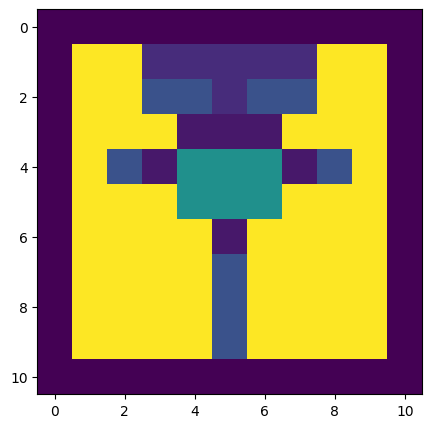

In [3]:
surgical_environment = SurgicalEnvironment()
surgical_grid = surgical_environment.create_environment()
surgical_environment.display_environment()

In [4]:
num_actions = surgical_environment.num_actions
input_shape = (surgical_environment.dimension + 1, surgical_environment.dimension + 1, 1)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_actions, activation='linear'))
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 16)          160       
                                                                 
 flatten (Flatten)           (None, 1296)              0         
                                                                 
 dense (Dense)               (None, 32)                41504     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 41,796
Trainable params: 41,796
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def preprocess_state(state):
    state = np.expand_dims(state, axis=0)  # Add batch dimension
    state = np.expand_dims(state, axis=-1)  # Add channel dimension
    state = state.astype('float32') / 255.0  # Normalize state values between 0 and 1
    return state

def experience_replay(training_model, replay_memory, minibatch_size, gamma=0.7):
    inputs = np.zeros((minibatch_size, *input_shape))
    targets = np.zeros((minibatch_size, num_actions))

    minibatch = np.random.choice(replay_memory, minibatch_size, replace=True)

    state_list = np.array(list(map(lambda x: x['s'], minibatch)))
    action_list = np.array(list(map(lambda x: x['a'], minibatch)))
    reward_list = np.array(list(map(lambda x: x['r'], minibatch)))
    s_prime_list = np.array(list(map(lambda x: x['s_prime'], minibatch)))
    done_list = np.array(list(map(lambda x: x['done'], minibatch)))

    for i, (s, a, r, sprime, done) in enumerate(zip(state_list, action_list, reward_list, s_prime_list, done_list)):
        inputs[i] = s
        targets[i] = training_model.predict(s)
        Q_sa = np.max(training_model.predict(sprime))
        if not done:
            targets[i, a] = r + gamma * Q_sa
        else:
            targets[i, a] = r

    training_model.fit(inputs, targets, epochs=10, verbose=0)
    return training_model

def animate_frame(i):
    im.set_array(frames[i])
    return [im]


In [ ]:
def train_and_evaluate(num_episodes, minibatch_size, memory_max_size, initial_epsilon, epsilon_decay, gamma, learning_rate):
    min_epsilon = 0.01
    reward_sums = []
    replay_memory = []

    # Training loop
    for episode in range(num_episodes):
        surgical_environment.reset_environment()
        done = False
        reward_sum = 0

        while not done:
            state = preprocess_state(surgical_environment.surgical_grid)

            if np.random.rand() < initial_epsilon:
                action = random.choice(surgical_environment.action_space)
            else:
                q_values = model.predict(state)
                action = np.argmax(q_values)

            next_state, reward, done, _ = surgical_environment.perform_action(action)
            reward_sum += reward

            replay_memory.append({'s': state, 'a': action, 'r': reward, 's_prime': preprocess_state(next_state), 'done': done})

            if len(replay_memory) > memory_max_size:
                replay_memory.pop(0)

            if len(replay_memory) >= minibatch_size:
                minibatch = random.sample(replay_memory, minibatch_size)
                inputs = np.zeros((minibatch_size, *input_shape))
                targets = np.zeros((minibatch_size, num_actions))

                for i, sample in enumerate(minibatch):
                    s, a, r, sprime, d = sample['s'], sample['a'], sample['r'], sample['s_prime'], sample['done']
                    inputs[i] = s
                    targets[i] = model.predict(s)
                    if not d:
                        targets[i, a] = r + gamma * np.max(model.predict(sprime))
                    else:
                        targets[i, a] = r

                model.fit(inputs, targets, epochs=1, verbose=0)

        initial_epsilon *= epsilon_decay
        initial_epsilon = max(initial_epsilon, min_epsilon)
        reward_sums.append(reward_sum)
        plt.plot(reward_sums, color='blue', linewidth=1)  # plot of the rewards
        if episode >= 3:  
            x = np.linspace(0, len(reward_sums), len(reward_sums), dtype=np.int32)
            z = np.polyfit(x, reward_sums, 3)
            p = np.poly1d(z)
            plt.plot(x, p(x), linewidth=2, color='orange')

        plt.title(f'Episode {episode+1},  \u03B5= {round(initial_epsilon, 3)},  Avg reward={round(mean(reward_sums), 3)}')

        if episode != num_episodes - 1:  # until the training is not finished
            plt.draw()
            plt.pause(1.0)
            plt.clf()
        else:
            plt.show()

        if episode % 10 == 0:
            print(f"Episode {episode}/{num_episodes}, Total Reward: {reward_sum}")

    # Save the trained model
    model.save('./improved_agent_' + str(num_episodes) + '_' + str(minibatch_size) + '_' + str(memory_max_size) + '_' + str(initial_epsilon) + '_' + str(epsilon_decay) + '_' + str(gamma) + '_' + str(learning_rate) + '.h5') 
    
    ## Testing

    trained_model = load_model('./improved_agent_' + str(num_episodes) + '_' + str(minibatch_size) + '_' + str(memory_max_size) + '_' + str(initial_epsilon) + '_' + str(epsilon_decay) + '_' + str(gamma) + '_' + str(learning_rate) + '.h5')  # loading the trained model

    test_environment = SurgicalEnvironment()
    test_environment.reset_environment()

    finished = False
    total_reward = 0
    frames = [test_environment.surgical_grid.copy()]  # create frames for animation

    while not finished:
        state = preprocess_state(test_environment.surgical_grid)
        q_values = trained_model.predict(state)
        action = np.argmax(q_values)
        _, reward, finished, info = test_environment.perform_action(action)
        print('Path:', info['path'])
        print('Actions:', info['actions_taken'])
        print()
        total_reward += reward

        frames.append(test_environment.surgical_grid.copy())  # store the frame

    print('Total reward:', total_reward)
    
    return total_reward


In [ ]:
# Define hyperparameter grid values to search through
num_episodes_values = [5000]
minibatch_size_values = [32, 64]
memory_max_size_values = [10000]
initial_epsilon_values = [1.0]
epsilon_decay_values = [0.996, 0.99]
gamma_values = [0.9, 0.95]
learning_rate_values = [0.001, 0.0001]

best_reward = float('-inf')
best_hyperparameters = None

# Perform the grid search
for num_episodes in num_episodes_values:
    for minibatch_size in minibatch_size_values:
        for memory_max_size in memory_max_size_values:
            for initial_epsilon in initial_epsilon_values:
                for epsilon_decay in epsilon_decay_values:
                    for gamma in gamma_values:
                        for learning_rate in learning_rate_values:
                            print(f"Training with hyperparameters - num_episodes: {num_episodes}, minibatch_size: {minibatch_size}, memory_max_size: {memory_max_size}, initial_epsilon: {initial_epsilon}, epsilon_decay: {epsilon_decay}, gamma: {gamma}, learning_rate: {learning_rate}")
                            reward = train_and_evaluate(num_episodes, minibatch_size, memory_max_size, initial_epsilon, epsilon_decay, gamma, learning_rate)
                            print(f"Hyperparameters eval: {num_episodes, minibatch_size, memory_max_size, initial_epsilon, epsilon_decay, gamma, learning_rate}, reward: {reward}")
                            if reward > best_reward:
                                best_reward = reward
                                best_hyperparameters = (num_episodes, minibatch_size, memory_max_size, initial_epsilon, epsilon_decay, gamma, learning_rate)

print(f"Best hyperparameters: {best_hyperparameters}, Best reward: {best_reward}")


In [ ]:
%matplotlib inline
# Hyperparameters
num_episodes = 10000
minibatch_size = 64
memory_max_size = 100000
initial_epsilon = 1.0
min_epsilon = 0.1
epsilon_decay = 0.996
gamma = 0.9

reward_sums = []
replay_memory = []

# Training loop
for episode in range(num_episodes):
    surgical_environment.reset_environment()
    done = False
    reward_sum = 0
    
    while not done:
        state = preprocess_state(surgical_environment.surgical_grid)
        
        if np.random.rand() < initial_epsilon:
            action = random.choice(surgical_environment.action_space)
        else:
            q_values = model.predict(state)
            action = np.argmax(q_values)
        
        next_state, reward, done, _ = surgical_environment.perform_action(action)
        reward_sum += reward

        replay_memory.append({'s': state, 'a': action, 'r': reward, 's_prime': preprocess_state(next_state), 'done': done})
        
        if len(replay_memory) > memory_max_size:
            replay_memory.pop(0)
        
        if len(replay_memory) >= minibatch_size:
            minibatch = random.sample(replay_memory, minibatch_size)
            inputs = np.zeros((minibatch_size, *input_shape))
            targets = np.zeros((minibatch_size, num_actions))
            
            for i, sample in enumerate(minibatch):
                s, a, r, sprime, d = sample['s'], sample['a'], sample['r'], sample['s_prime'], sample['done']
                inputs[i] = s
                targets[i] = model.predict(s)
                if not d:
                    targets[i, a] = r + gamma * np.max(model.predict(sprime))
                else:
                    targets[i, a] = r
            
            model.fit(inputs, targets, epochs=1, verbose=0)

    initial_epsilon *= epsilon_decay
    initial_epsilon = max(initial_epsilon, min_epsilon)
    reward_sums.append(reward_sum)
    plt.plot(reward_sums, color='blue', linewidth=1)  # plot of the rewards
    if episode >= 3:  # after 3 episodes, plot the trend line
        x = np.linspace(0, len(reward_sums), len(reward_sums), dtype=np.int32)
        z = np.polyfit(x, reward_sums, 3)
        p = np.poly1d(z)
        plt.plot(x, p(x), linewidth=2, color='orange')

    plt.title(f'Episode {episode+1},  \u03B5= {round(initial_epsilon, 3)},  Avg reward={round(mean(reward_sums), 3)}')

    if episode != num_episodes - 1:  # until the training is not finished
        plt.draw()
        plt.pause(1.0)
        plt.clf()
    else:
        plt.show()

    if episode % 10 == 0:
        print(f"Episode {episode}/{num_episodes}, Total Reward: {reward_sum}")

# Save the trained model
model.save('./agent' + str(num_episodes) + '.h5')


In [ ]:
# Testing
trained_agent = load_model('./agent10000.h5')  # loading the trained agent model

test_environment = SurgicalEnvironment()
test_environment.reset_environment()
frames = [test_environment.surgical_grid.copy()]  # create frames for animation
finished = False
total_reward = 0


while not finished:
    state = preprocess_state(test_environment.surgical_grid)
    q_values = trained_agent.predict(state)
    action = np.argmax(q_values)
    _, reward, finished, info = test_environment.perform_action(action)
    print('Path:', info['path_history'])
    print('Actions:', info['actions_taken'])
    print()
    total_reward += reward

    frames.append(test_environment.surgical_grid.copy())  # store the frame

print('Total reward:', total_reward)


In [ ]:
%%capture

plt.rcParams["animation.html"] = "jshtml"

fps = len(frames)
n_seconds = len(frames)

fig = plt.figure(figsize=(5, 5))

a = frames[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=255)
anim = FuncAnimation(
    fig,
    animate_frame,
    frames=len(frames),
    interval=10000 / fps,  # ms
)

anim.save('./agent_' + str(num_episodes) + '.gif', writer='imagemagick', fps=int(fps / 2))
